In [1]:
## Loading required modules

import numpy as np
import pandas as pd

import pandas_profiling as pp

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Loading survey responses data and subsetting for analysts

df = pd.read_csv('kaggle_survey_2020_responses.csv')
df.shape

/Users/ankitshukla/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(20037, 355)

## Data Understanding

In [3]:
## Listing columns

for col in df.columns:
    print(col)

Time from Start to Finish (seconds)
Q1
Q2
Q3
Q4
Q5
Q6
Q7_Part_1
Q7_Part_2
Q7_Part_3
Q7_Part_4
Q7_Part_5
Q7_Part_6
Q7_Part_7
Q7_Part_8
Q7_Part_9
Q7_Part_10
Q7_Part_11
Q7_Part_12
Q7_OTHER
Q8
Q9_Part_1
Q9_Part_2
Q9_Part_3
Q9_Part_4
Q9_Part_5
Q9_Part_6
Q9_Part_7
Q9_Part_8
Q9_Part_9
Q9_Part_10
Q9_Part_11
Q9_OTHER
Q10_Part_1
Q10_Part_2
Q10_Part_3
Q10_Part_4
Q10_Part_5
Q10_Part_6
Q10_Part_7
Q10_Part_8
Q10_Part_9
Q10_Part_10
Q10_Part_11
Q10_Part_12
Q10_Part_13
Q10_OTHER
Q11
Q12_Part_1
Q12_Part_2
Q12_Part_3
Q12_OTHER
Q13
Q14_Part_1
Q14_Part_2
Q14_Part_3
Q14_Part_4
Q14_Part_5
Q14_Part_6
Q14_Part_7
Q14_Part_8
Q14_Part_9
Q14_Part_10
Q14_Part_11
Q14_OTHER
Q15
Q16_Part_1
Q16_Part_2
Q16_Part_3
Q16_Part_4
Q16_Part_5
Q16_Part_6
Q16_Part_7
Q16_Part_8
Q16_Part_9
Q16_Part_10
Q16_Part_11
Q16_Part_12
Q16_Part_13
Q16_Part_14
Q16_Part_15
Q16_OTHER
Q17_Part_1
Q17_Part_2
Q17_Part_3
Q17_Part_4
Q17_Part_5
Q17_Part_6
Q17_Part_7
Q17_Part_8
Q17_Part_9
Q17_Part_10
Q17_Part_11
Q17_OTHER
Q18_Part_1
Q18_Part_2
Q18_Part_

In [4]:
## Listing Questions

for ques in df.loc[0]:
    print(ques)

Duration (in seconds)
What is your age (# years)?
What is your gender? - Selected Choice
In which country do you currently reside?
What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
Select the title most similar to your current role (or most recent title if retired): - Selected Choice
For how many years have you been writing code and/or programming?
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++
What programming languages do you use on a regular basis? 

In [5]:
## Preparing a dataframe containing question numbers and questions

q_df = pd.DataFrame({'q_header': list(df.columns),
                     'question' : list(df.loc[0])})

# Extracting questions numbers from question headers
q_df['ques_num'] = q_df.q_header.str.split('_').apply(lambda x : x[0])


## Extracting question keys from question headers
def ques_keys(x):
    if x.find('_A_') != -1:
        str_out = x.split('_')[0] + '_A'
    elif x.find('_B_') != -1:
        str_out = x.split('_')[0] + '_B'
    else:
        str_out = x.split('_')[0]
    return str_out

q_df['ques_keys'] = q_df.q_header.apply(lambda x: ques_keys(x))


# Question type
q_count = q_df.groupby('ques_keys').size().reset_index()
q_count.columns = ['ques_keys','ques_count']
q_count['ques_type'] = np.where(q_count.ques_count > 1, 'multiple_answer', 'single_answer')
q_df = pd.merge(q_df, q_count[['ques_keys','ques_type']], how = 'left', left_on = 'ques_keys', right_on = 'ques_keys')


# Re-arranging columns
q_df = q_df[['q_header','ques_keys','ques_num','ques_type','question']]

# removing survey time from q_df
q_df.drop(0, axis = 0, inplace = True)

# Print dimesnions
print(q_df.shape)

# data sample
q_df.head()

(354, 5)


,q_header,ques_keys,ques_num,ques_type,question
1,Q1,Q1,Q1,single_answer,What is your age (# years)?
2,Q2,Q2,Q2,single_answer,What is your gender? - Selected Choice
3,Q3,Q3,Q3,single_answer,In which country do you currently reside?
4,Q4,Q4,Q4,single_answer,What is the highest level of formal education ...
5,Q5,Q5,Q5,single_answer,Select the title most similar to your current ...


In [6]:
## Computing missing value percentages for every question

def missing_value_perc(ques_num):
    if q_df.ques_type[q_df.ques_num == ques_num].reset_index(drop = True)[0] == 'single_answer':
        mv_perc = df[ques_num].isnull().sum()/df.shape[0]*100
    else:
       column_list = list(q_df.q_header[q_df.ques_num == ques_num])
       mv_perc = pd.isnull(df[column_list].bfill(axis=1).iloc[:, 0]).sum()/df.shape[0]*100
    return round(mv_perc, 2)


ques_num = q_df.ques_num.unique()
missing_perc = pd.Series(ques_num).apply(lambda x: missing_value_perc(x))


ques_missing_perc = pd.DataFrame({'ques_num': ques_num,
                                'missing_perc': missing_perc})


ques_missing_perc.sort_values(by = 'missing_perc', ascending = False, inplace = True)
ques_missing_perc

,ques_num,missing_perc
31,Q32,92.52
29,Q30,82.46
18,Q19,80.69
17,Q18,70.49
35,Q36,66.93
33,Q34,63.11
24,Q25,47.24
23,Q24,46.45
22,Q23,45.62
21,Q22,44.45


In [7]:
q_df.question[q_df.ques_num == 'Q19'].unique()

array(['Which of the following natural language processing (NLP) methods do you use on a regular basis?  (Select all that apply) - Selected Choice - Word embeddings/vectors (GLoVe, fastText, word2vec)',
       'Which of the following natural language processing (NLP) methods do you use on a regular basis?  (Select all that apply) - Selected Choice - Encoder-decorder models (seq2seq, vanilla transformers)',
       'Which of the following natural language processing (NLP) methods do you use on a regular basis?  (Select all that apply) - Selected Choice - Contextualized embeddings (ELMo, CoVe)',
       'Which of the following natural language processing (NLP) methods do you use on a regular basis?  (Select all that apply) - Selected Choice - Transformer language models (GPT-3, BERT, XLnet, etc)',
       'Which of the following natural language processing (NLP) methods do you use on a regular basis?  (Select all that apply) - Selected Choice - None',
       'Which of the following natural 

In [8]:
## Loading question tag mapping (manually created)

q_tag = pd.read_csv('Question_Tags_Kaggle_Survey_2020.csv')
print(q_tag.shape)
q_tag

(39, 2)


,ques_num,tag
0,Q1,age
1,Q2,gender
2,Q3,country of residence
3,Q4,education
4,Q5,current role
5,Q6,coding experience
6,Q7,programming languages
7,Q8,programming language recommendation
8,Q9,IDE
9,Q10,Notebook Products


In [9]:
## Combining the missing percentage & tags data to the q_df dataframe

q_df = pd.merge(q_df, ques_missing_perc, how = 'left', left_on = 'ques_num', right_on = 'ques_num')
q_df = pd.merge(q_df, q_tag, how = 'left', left_on = 'ques_num', right_on = 'ques_num')
q_df

,q_header,ques_keys,ques_num,ques_type,question,missing_perc,tag
0,Q1,Q1,Q1,single_answer,What is your age (# years)?,0.00,age
1,Q2,Q2,Q2,single_answer,What is your gender? - Selected Choice,0.00,gender
2,Q3,Q3,Q3,single_answer,In which country do you currently reside?,0.00,country of residence
3,Q4,Q4,Q4,single_answer,What is the highest level of formal education ...,2.33,education
4,Q5,Q5,Q5,single_answer,Select the title most similar to your current ...,3.79,current role
...,...,...,...,...,...,...,...
349,Q35_B_Part_7,Q35_B,Q35,multiple_answer,"In the next 2 years, do you hope to become mor...",32.56,Experiments Tracking
350,Q35_B_Part_8,Q35_B,Q35,multiple_answer,"In the next 2 years, do you hope to become mor...",32.56,Experiments Tracking
351,Q35_B_Part_9,Q35_B,Q35,multiple_answer,"In the next 2 years, do you hope to become mor...",32.56,Experiments Tracking
352,Q35_B_Part_10,Q35_B,Q35,multiple_answer,"In the next 2 years, do you hope to become mor...",32.56,Experiments Tracking


In [10]:
## Writing the q_df to disk

q_df.to_csv('questions_dataframe.csv', index = False)

## Generating Insights

In [11]:
## Survey responses data without questions

dat = df.loc[1:,]
dat.shape

(20036, 355)

In [12]:
## Helper Functions


# Calculating the # of responders for each category
def insights(question):
    
    if q_df.ques_type[q_df.ques_keys == question].unique()[0] == 'single_answer':
        perc_responders = dat[question].value_counts()/dat.shape[0]*100
        perc_responders = perc_responders.reset_index()
        perc_responders.columns = ['Index', 'Responder_Percetage']
        perc_responders.sort_values(by = 'Responder_Percetage', ascending = False, inplace = True)
        
    else:
        list_of_columns = list(q_df.q_header[q_df.ques_keys == question])
        perc_responders = dat[list_of_columns[0]].value_counts().reset_index()
        perc_responders.columns = ['Index','num_responders']

        for col in list_of_columns[1:]:
            resp_count = dat[col].value_counts().reset_index()
            resp_count.columns = ['Index','num_responders']
            perc_responders = perc_responders.append(resp_count)
        
        perc_responders['Responder_Percetage'] = perc_responders.num_responders/dat.shape[0]*100
        perc_responders = perc_responders[['Index','Responder_Percetage']]
        perc_responders.sort_values(by = 'Responder_Percetage', ascending = False, inplace = True)
        
    return perc_responders


# Plotting the # of responders using bar plots
def dist_bar_plots(title, xlabel, ylabel, transpose = False):
    fig_dims = (12, 6)
    fig, ax = plt.subplots(figsize=fig_dims)
    if transpose == False:
        sns.barplot(data = perc_responders, x = 'Index', y = 'Responder_Percetage')
    else: 
        sns.barplot(data = perc_responders, y = 'Index', x = 'Responder_Percetage')
    ax.set(xlabel=xlabel, ylabel=ylabel, title = title)
    plt.show()

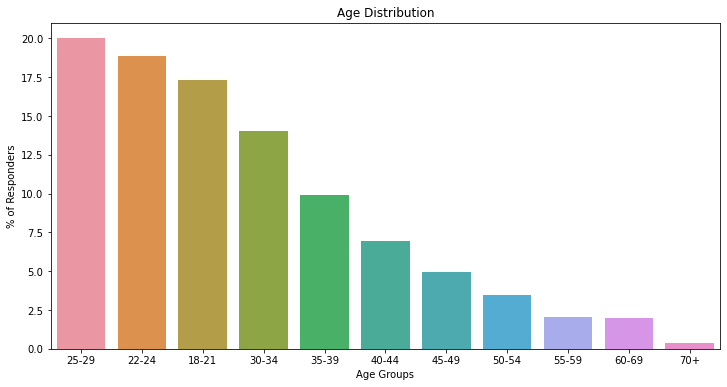

In [13]:
## Q1 - Age

perc_responders = insights('Q1')

title = 'Age Distribution'
xlabel = 'Age Groups'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel)

Most People active in the data science space are quite young and lie in 18-34 age bracket.

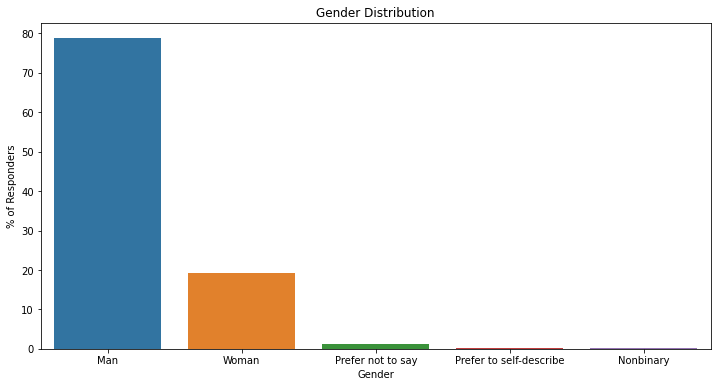

In [14]:
## Q2 - Gender

perc_responders = insights('Q2')

title = 'Gender Distribution'
xlabel = 'Gender'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel)

The data science space is largely male dominated with 79% male responders 

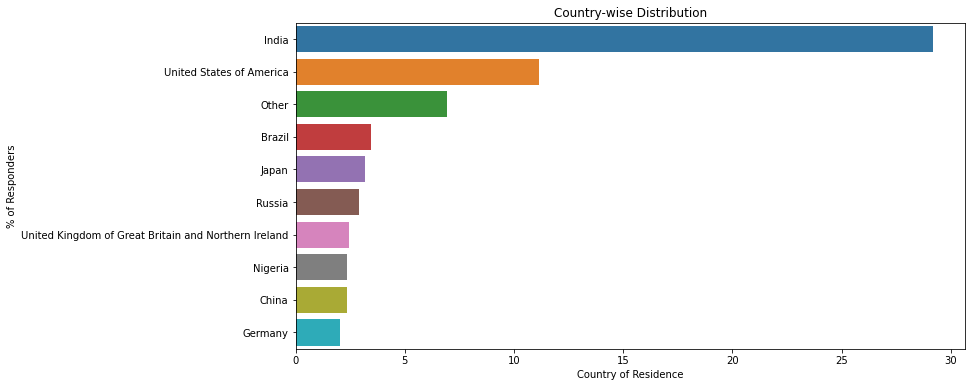

In [15]:
## Q3 - Country Of Residence

perc_responders = insights('Q3')
perc_responders = perc_responders.head(10)

title = 'Country-wise Distribution'
xlabel = 'Country of Residence'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel, transpose = True)

India & The US lead in terms of number of data enthusiasts followed by Brazil, Japan & Russia

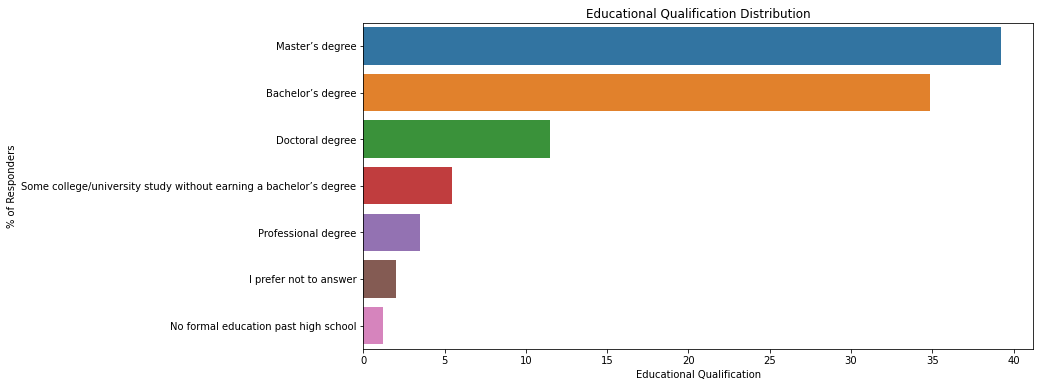

In [16]:
## Q4 - Educational Qualification/Degree

perc_responders = insights('Q4')

title = 'Educational Qualification Distribution'
xlabel = 'Educational Qualification'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel, transpose = True)

Most data enthusiasts have some college degree (either master's or bachelor's followed by doctorates)

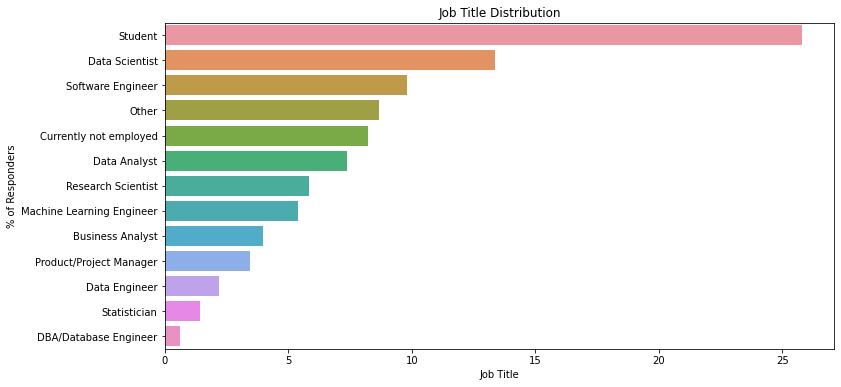

In [17]:
## Q5 - Job Title

perc_responders = insights('Q5')

title = 'Job Title Distribution'
xlabel = 'Job Title'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel, transpose = True)

Students form a quarter of the responders followed by data scientists & analysts (data/business)

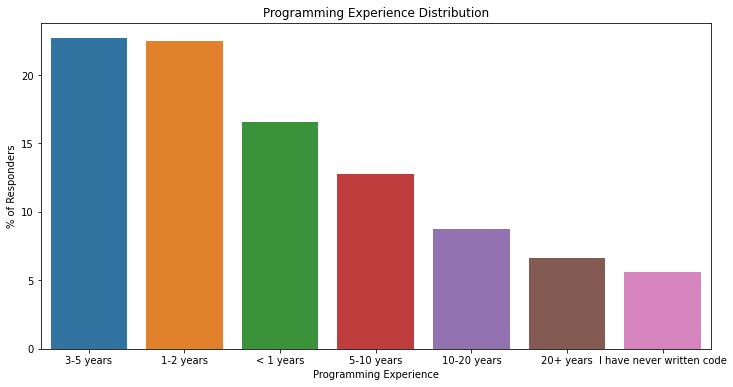

In [18]:
## Q6 - Programming Experience

perc_responders = insights('Q6')

title = 'Programming Experience Distribution'
xlabel = 'Programming Experience'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel)

In [19]:
perc_responders

,Index,Responder_Percetage
0,3-5 years,22.689160
1,1-2 years,22.484528
2,< 1 years,16.535237
3,5-10 years,12.737073
4,10-20 years,8.739269
5,20+ years,6.633060
6,I have never written code,5.609902


60% of the responders lie in 0-5 years bracket. Around 5% of the responders have never written code

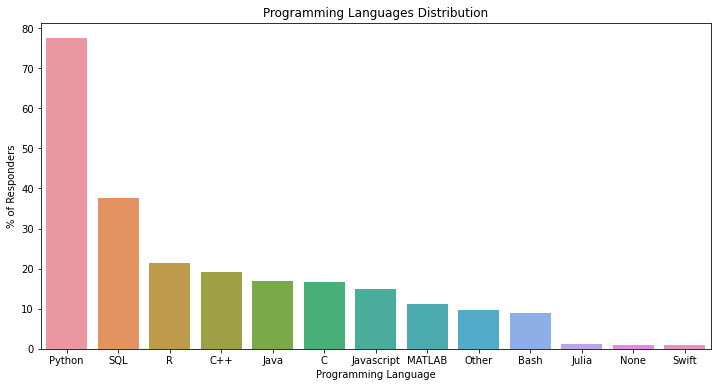

In [20]:
## Q7 - Programming Language

perc_responders = insights('Q7')

title = 'Programming Languages Distribution'
xlabel = 'Programming Language'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel)

Python is the most popular programming language followed by R & SQL

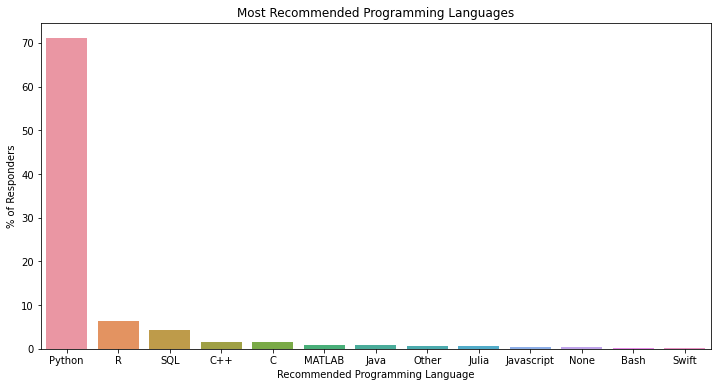

In [21]:
## Q8 - Recommended Programming Language

perc_responders = insights('Q8')

title = 'Most Recommended Programming Languages'
xlabel = 'Recommended Programming Language'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel)

Python is the most recommended programming language for aspiring data enthusiasts followed by R & SQL

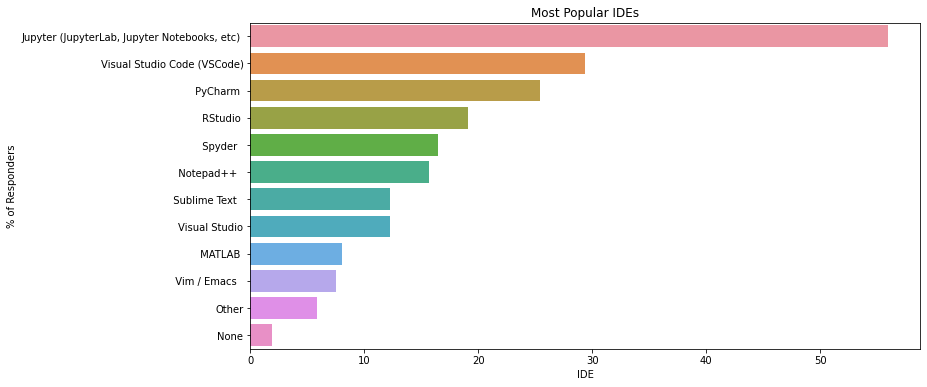

In [22]:
## Q9 - IDE

perc_responders = insights('Q9')

title = 'Most Popular IDEs'
xlabel = 'IDE'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel, transpose = True)

The popularity of Jupyter Notebooks among data enthusiasts supersedes everything else. VS Code, PyCharm & RStudio are quite popular as well.

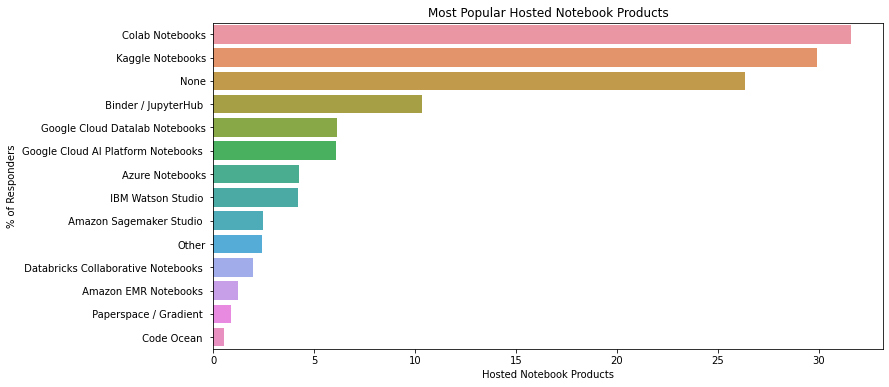

In [23]:
## Q10 - Hosted Notebook Products

perc_responders = insights('Q10')

title = 'Most Popular Hosted Notebook Products'
xlabel = 'Hosted Notebook Products'
ylabel = '% of Responders'

dist_bar_plots(title, xlabel, ylabel, transpose = True)

Among hosted notebook products, Google Colab & Kaggle notebooks lead the pack. Google cloud is quite ahead from the competitors Amazon & Micorosoft